## Lab 13.

In this Lab we will focus on Adversarial Examples.


The code in this notebook has been borrowed from the "Craft Image Adversarial Samples with Tensorflow" repository,  available in https://github.com/gongzhitaao/tensorflow-adversarial

We will also use material from the book "Hands-On Machine Learning with Scikit-Learn and TensorFlow. Concepts, Tools, and Techniques to Build Intelligent Systems" by Aurélien Géron, that it is recommended as Bibliography of the course. http://shop.oreilly.com/product/0636920052289.do 

In [20]:
# We start by importing the python libraries required to solve the problems

import os
# supress tensorflow logging other than errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn import ModeKeys, Estimator
from tensorflow.examples.tutorials.mnist import input_data
import neat
import random
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# from attacks.fgsm import fgsm
import warnings
warnings.filterwarnings('ignore')

In [45]:
# This function sets the seeds of the stochastic functions
# to make the output of this notebook stable across runs

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # This line forces tensorflow to use the CPU instead of the GPU
    # I did this because had problems with my CPU. You can set 'GPU': 1
    config = tf.ConfigProto(device_count = {'GPU': 0})

 As a baseline dataset we use the the MNIST dataset that is loaded here


In [44]:
img_rows = 28
img_cols = 28
img_chas = 1
input_shape = (img_rows, img_cols, img_chas)
n_classes = 10


# We import the MNIST dataset
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

print('\nLoading mnist')

# The train and test sets are defined 
X_train = mnist.train.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_test = mnist.test.labels.astype("int")

#(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = X_train.reshape(-1, img_rows, img_cols, img_chas)
X_test = X_test.reshape(-1, img_rows, img_cols, img_chas)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz

Loading mnist


## Adversarial Examples 

Adversarial examples (https://arxiv.org/pdf/1412.6572.pdf) are inputs formed by applying small but intentionally worst-case perturbations to examples from the dataset, such that the perturbed input results in the model outputting an incorrect answer with high confidence.

In this lab we will learn:

1. What functions we can use to create adversarial examples.
2. How to use the functions that create the adversarial examples.
3. What is the effect of the adversarial example in the acccuracy of the model.




### Method to create adversarial examples 

The following cell contains the implementation of the  Fast Gradient Sign Method (FGSM). This method receives an observation (e.g., an MNIST image) and a model that outputs a correct classification of the image (e.g., a DNN classifier). FGSM outputs an image that is a pertubation of the original image, and makes the model to produce an incorrect classification. 

Several algorithms for creating adversarial examples exist, each of which operate in different ways to achieve their goal. 
FSGM finds adversarial perturbations which increase the value of the loss function (the one that we usually try to minimize during training).



In [4]:
reset_graph()

In [42]:
def fgsm(model, x, eps=0.01, epochs=1, clip_min=0., clip_max=1.):
    """
    Fast gradient sign method.

    See https://arxiv.org/abs/1412.6572 and https://arxiv.org/abs/1607.02533
    for details. This function implements the revised version, since the original FGSM
    has label leaking problem (https://arxiv.org/abs/1611.01236).

    :param model: A wrapper that returns the output as well as logits.
    :param x: The input placeholder.
    :param eps: The scale factor for noise.
    :param epochs: The number of epoch to run.
    :param clip_min: The minimum value in output.
    :param clip_max: The maximum value in output.

    :return: A tensor, contains adversarial samples for each input.
    """
    
    # x_adv will contain the adversarial example
    x_adv = tf.identity(x)

    # This is the classification given by the model to the original observation    
    ybar = model(x_adv)
    
    # Number of possible values for the target class variable
    ydim = ybar.get_shape().as_list()[1]
    
    # Classes for which the prediction is maximized 
    indices = tf.argmax(ybar, axis=1)
    
    
    # If the dimension of the target variable is 1, then 
    # target is 0 or 1 according to whether the prob. is <0.5 or > 0.5
    # If the dimension of the target variable is > 1, then 
    # then the target is the class that maximizes the probability
    
    target = tf.cond(
        tf.equal(ydim, 1),
        lambda: tf.nn.relu(tf.sign(ybar - 0.5)),
        lambda: tf.one_hot(indices, ydim, on_value=1.0, off_value=0.0))
    

    # The loss_function is sigmoid or softmax according to the number
    # of classes
    if 1 == ydim:
        loss_fn = tf.nn.sigmoid_cross_entropy_with_logits
    else:
        loss_fn = tf.nn.softmax_cross_entropy_with_logits_v2

    # The scale factor is taken as positive    
    eps = tf.abs(eps)

    # Conditional check for the while (maximum number of epochs)
    def _cond(x_adv, i):
        return tf.less(i, epochs)

    # This is the essential part of the FSGM procedure    
    def _body(x_adv, i):
        
        # We get the prediction (and the logits) of the model
        ybar, logits = model(x_adv, logits=True)
        
        # We also compute the probability for the target
        loss = loss_fn(labels=target, logits=logits)
        
        # The gradient gives us the direction of maximum improvement
        # of the loss function for each component (pixel) of the observation
        dy_dx, = tf.gradients(loss, x_adv)
        
        # We use the gradient to "move" the adversarial example in the direction
        # of the gradient (instead of going in the opposite direction to minimize loss)
        x_adv = tf.stop_gradient(x_adv + eps*tf.sign(dy_dx))
        
        # Finally, the adversarial example is clipped 
        x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)
        return x_adv, i+1

    x_adv, _ = tf.while_loop(_cond, _body, (x_adv, 0), back_prop=False,
                             name='fgsm')
    return x_adv


### Convolutional Network model

In order to test FGSM, we need a model. In the following cell we define a convolutional network (similar to the ones we have practiced with in the lab before). 

In [43]:
def model(x, logits=False, training=False):
    
    
    conv0 = tf.layers.conv2d(x, filters=36, kernel_size=[3, 3],
                             padding='same', name='conv0',
                             activation=tf.nn.relu)
    
    pool0 = tf.layers.max_pooling2d(conv0, pool_size=[2, 2],
                                    strides=2, name='pool0')
    
    conv1 = tf.layers.conv2d(pool0, filters=36,
                             kernel_size=[3, 3], padding='same',
                             name='conv1', activation=tf.nn.relu)
    
    pool1 = tf.layers.max_pooling2d(conv1, pool_size=[2, 2],
                                    strides=2, name='pool1')
    
    conv2 = tf.layers.conv2d(pool1, filters=36,
                             kernel_size=[3, 3], padding='same',
                             name='conv1', activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(conv2, pool_size=[2, 2],
                                    strides=2, name='pool1')
    
    
    flat = tf.layers.Flatten()(pool2)
    
    dense = tf.layers.dense(flat, units=576, activation=tf.nn.relu,
                            name='dense')
    
    dropout = tf.layers.dropout(dense, rate=0.2, training=training,
                                name='dropout')
    
    logits_ = tf.layers.dense(dropout, units=10, name='logits')
    y = tf.nn.softmax(logits_, name='ybar')
    if logits:
        return y, logits_
    return y




### Defining model loss function and optimizer

Once the network has been defined. We specify the pipeline to train it, including the loss function that we want to optimize (in this example, softmax_cross_entropy_with_logits)

In [46]:
# Collect all tensorflow tensors into one "enviroment" to avoid
# accidental overwriting.
class Dummy:
    pass
env = Dummy()

# We need a scope since the inference graph will be reused later
with tf.variable_scope('model', reuse=tf.AUTO_REUSE):
    env.x = tf.placeholder(tf.float32, (None, img_rows, img_cols,
                                        img_chas), name='x')
    env.y = tf.placeholder(tf.float32, (None, n_classes), name='y')
    env.training = tf.placeholder(bool, (), name='mode')

    env.ybar, logits = model(env.x, logits=True,
                             training=env.training)

    z = tf.argmax(env.y, axis=1)
    zbar = tf.argmax(env.ybar, axis=1)
    count = tf.cast(tf.equal(z, zbar), tf.float32)
    env.acc = tf.reduce_mean(count, name='acc')

    xent = tf.nn.softmax_cross_entropy_with_logits_v2(labels=env.y,
                                                   logits=logits)
    env.loss = tf.reduce_mean(xent, name='loss')

    env.optim = tf.train.AdamOptimizer().minimize(env.loss)

We will also use the model to find the adversarial samples, using the FGSM method, as defined before.

In [8]:
# Note the reuse=True flag
with tf.variable_scope('model', reuse=True):
    env.x_adv = fgsm(model, env.x, epochs=12, eps=0.02)    

We will split the train set into a validation set and a  "reduced" train set. Later we will know what do we need the validation set for. 

In [9]:
print('\nShuffling training data')
ind = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train[ind], y_train[ind]

# split training/validation dataset
validation_split = 0.1
n_train = int(X_train.shape[0]*(1-validation_split))
X_valid = X_train[n_train:]
X_train = X_train[:n_train]
y_valid = y_train[n_train:]
y_train = y_train[:n_train]


Shuffling training data


### Training the network

The tensorflow graph session is defined 

In [10]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

Functions _evaluate and _predict implement the training of the network and the predictio, respectively. They are a modular way to organize the learning process. 

In [11]:
def _evaluate(X_data, y_data, env):
    print('\nEvaluating')
    n_sample = X_data.shape[0]
    batch_size = 128
    n_batch = int(np.ceil(n_sample/batch_size))
    loss, acc = 0, 0
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        batch_loss, batch_acc = sess.run(
            [env.loss, env.acc],
            feed_dict={env.x: X_data[start:end],
                       env.y: y_data[start:end],
                       env.training: False})
        loss += batch_loss*batch_size
        acc += batch_acc*batch_size
    loss /= n_sample
    acc /= n_sample
    print(' loss: {0:.4f} acc: {1:.4f}'.format(loss, acc))
    return loss, acc


def _predict(X_data, env):
    print('\nPredicting')
    n_sample = X_data.shape[0]
    batch_size = 128
    n_batch = int(np.ceil(n_sample/batch_size))
    yval = np.empty((X_data.shape[0], n_classes))
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        batch_y = sess.run(env.ybar, feed_dict={
            env.x: X_data[start:end], env.training: False})
        yval[start:end] = batch_y
    print()
    return yval



In the following cell the model is learned using the reduced train dataset and creating minibatches as we have done many times before. The validation set, that is NOT used for training, is used to estimate the quality of the model.

The algorithm prints the accuracy and the loss function for this train data and also, at the end, for the test data. 

In [12]:
print('\nTraining')
n_sample = X_train.shape[0]
batch_size = 128
n_batch = int(np.ceil(n_sample/batch_size))

n_epoch = 2 # More epochs might be needed
for epoch in range(n_epoch):
    print('Epoch {0}/{1}'.format(epoch+1, n_epoch))
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        sess.run(env.optim, feed_dict={env.x: X_train[start:end],
                                       env.y: y_train[start:end],
                                       env.training: True})
    _evaluate(X_valid, y_valid, env)
    

print('\nTesting against clean data')
_evaluate(X_test, y_test, env)

save_path = saver.save(sess, "/tmp/mnist_model.ckpt")
print("Model saved in file: %s" % save_path)


Training
Epoch 1/2
 batch 387/387
Evaluating
 loss: 0.4218 acc: 0.8679
Epoch 2/2
 batch 387/387
Evaluating
 loss: 0.2303 acc: 0.9289

Testing against clean data

Evaluating
 loss: 0.2250 acc: 0.9426
Model saved in file: /tmp/mnist_model.ckpt


Notice, in the results of the learning process, that the accuracy of the model was high, above 0.94 in my case. 

### Learning adversarial examples using FGSM

In the next cell the adversarial examples are created from the test data. Notice that tmp stores the output of the FGSM procedure as implemented within the environment env.

In [50]:
print('\nCrafting adversarial')
n_sample = X_test.shape[0]
batch_size = 128
n_batch = int(np.ceil(n_sample/batch_size))
n_epoch = 20
X_adv = np.empty_like(X_test)
for ind in range(n_batch):
    print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
    start = ind*batch_size
    end = min(n_sample, start+batch_size)
    tmp = sess.run(env.x_adv, feed_dict={env.x: X_test[start:end],
                                         env.y: y_test[start:end],
                                         env.training: False})
    X_adv[start:end] = tmp
print('\nSaving adversarial')
os.makedirs('data', exist_ok=True)
np.save('data/ex_00.npy', X_adv)


Crafting adversarial


KeyboardInterrupt: 

We evaluate the accuracy of the model for the created adversarial examples (expect it to be low and compare with the accuracy values that we have previously obtained with the same model). 

In [ ]:
print('\nTesting against adversarial data')
_evaluate(X_adv, y_test, env)

The following cell visualizes one adversarial example for each of the ten digits. Run the script and visualize the file img/ex_00.png



In [15]:
y1 = _predict(X_test, env)
y2 = _predict(X_adv, env)

z0 = np.argmax(y_test, axis=1)
z1 = np.argmax(y1, axis=1)
z2 = np.argmax(y2, axis=1)

X_tmp = np.empty((10, 28, 28))
y_tmp = np.empty((10, 10))

for i in range(10):
    print('Target {0}'.format(i))
    ind, = np.where(np.all([z0==i, z1==i, z2!=i], axis=0))
    cur = np.random.choice(ind)

    X_tmp[i] = np.squeeze(X_adv[cur])
    y_tmp[i] = y2[cur]

print('\nPlotting results')
fig = plt.figure(figsize=(10, 1.8))
gs = gridspec.GridSpec(1, 10, wspace=0.1, hspace=0.1)

label = np.argmax(y_tmp, axis=1)
proba = np.max(y_tmp, axis=1)
for i in range(10):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(X_tmp[i], cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('{0} ({1:.2f})'.format(label[i], proba[i]),
                  fontsize=12)

print('\nSaving figure')
gs.tight_layout(fig)
os.makedirs('img', exist_ok=True)
plt.savefig('img/ex_00.png')


Predicting
 batch 79/79

Predicting
 batch 79/79
Target 0
Target 1
Target 2
Target 3
Target 4
Target 5
Target 6
Target 7
Target 8
Target 9

Plotting results

Saving figure


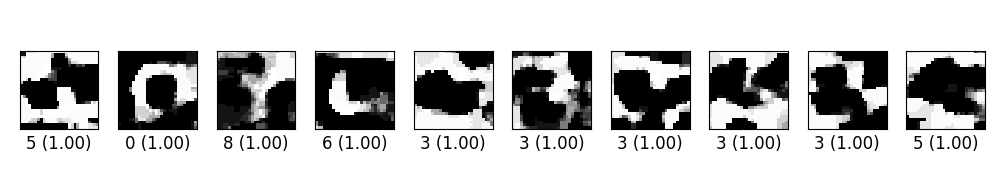

In [17]:
from PIL import Image
Image.open("img/ex_00.png")

# Exercise 1


Modify the value of epsilon and observe the effect on the generated adversarial examples.
Change the directory in which the images are saved to see the differences

In [55]:
# Note the reuse=True flag
with tf.variable_scope('model', reuse=True):
    env.x_adv = fgsm(model, env.x, epochs=12, eps=0.000013)   

In [56]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [57]:
print('\nTraining')
n_sample = X_train.shape[0]
batch_size = 128
n_batch = int(np.ceil(n_sample/batch_size))

n_epoch = 2 # More epochs might be needed
for epoch in range(n_epoch):
    print('Epoch {0}/{1}'.format(epoch+1, n_epoch))
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        sess.run(env.optim, feed_dict={env.x: X_train[start:end],
                                       env.y: y_train[start:end],
                                       env.training: True})
    _evaluate(X_valid, y_valid, env)
    

print('\nTesting against clean data')
_evaluate(X_test, y_test, env)

save_path = saver.save(sess, "/tmp/mnist_model.ckpt")
print("Model saved in file: %s" % save_path)


Training
Epoch 1/2
 batch 430/430
Evaluating
 loss: 0.4987 acc: 0.8297
Epoch 2/2
 batch 430/430
Evaluating
 loss: 0.2836 acc: 0.9059

Testing against clean data

Evaluating
 loss: 0.2673 acc: 0.9252
Model saved in file: /tmp/mnist_model.ckpt


In [58]:
print('\nCrafting adversarial')
n_sample = X_test.shape[0]
batch_size = 128
n_batch = int(np.ceil(n_sample/batch_size))
n_epoch = 20
X_adv = np.empty_like(X_test)
for ind in range(n_batch):
    print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
    start = ind*batch_size
    end = min(n_sample, start+batch_size)
    tmp = sess.run(env.x_adv, feed_dict={env.x: X_test[start:end],
                                         env.y: y_test[start:end],
                                         env.training: False})
    X_adv[start:end] = tmp
print('\nSaving adversarial')
os.makedirs('data', exist_ok=True)
np.save('data/ex_01.npy', X_adv)


Crafting adversarial
 batch 79/79
Saving adversarial


In [59]:
print('\nTesting against adversarial data')
_evaluate(X_adv, y_test, env)


Testing against adversarial data

Evaluating
 loss: 0.4638 acc: 0.8161


(0.46383741760253905, 0.8161)

In [60]:
y1 = _predict(X_test, env)
y2 = _predict(X_adv, env)

z0 = np.argmax(y_test, axis=1)
z1 = np.argmax(y1, axis=1)
z2 = np.argmax(y2, axis=1)

X_tmp = np.empty((10, 28, 28))
y_tmp = np.empty((10, 10))

for i in range(10):
    print('Target {0}'.format(i))
    ind, = np.where(np.all([z0==i, z1==i, z2!=i], axis=0))
    cur = np.random.choice(ind)

    X_tmp[i] = np.squeeze(X_adv[cur])
    y_tmp[i] = y2[cur]

print('\nPlotting results')
fig = plt.figure(figsize=(10, 1.8))
gs = gridspec.GridSpec(1, 10, wspace=0.1, hspace=0.1)

label = np.argmax(y_tmp, axis=1)
proba = np.max(y_tmp, axis=1)
for i in range(10):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(X_tmp[i], cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('{0} ({1:.2f})'.format(label[i], proba[i]),
                  fontsize=12)

print('\nSaving figure')
gs.tight_layout(fig)
os.makedirs("img", exist_ok=True)
plt.savefig("img" + '/ex_01.png')


Predicting
 batch 79/79

Predicting
 batch 79/79
Target 0
Target 1
Target 2
Target 3
Target 4
Target 5
Target 6
Target 7
Target 8
Target 9

Plotting results

Saving figure


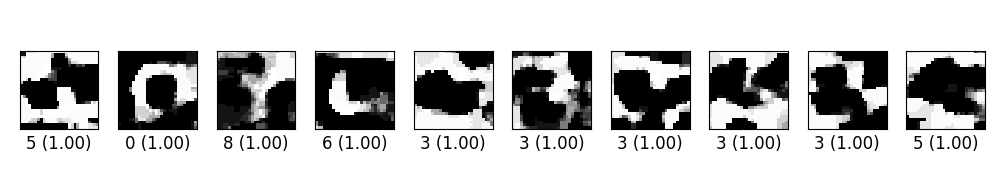

In [61]:
Image.open("img/ex_00.png")

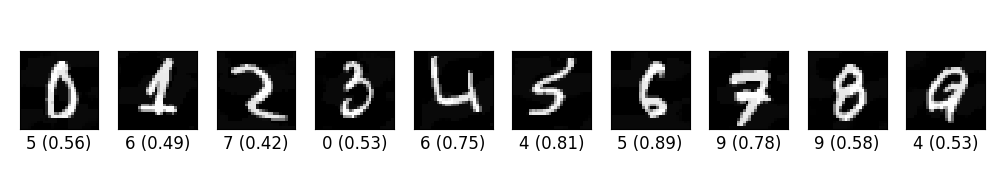

In [62]:
Image.open("img/ex_01.png")

# Exercise 2 

 2.1) Reuse the CNN and the code in the following cell to generate adversarial examples for the fashion dataset.
 
 2.2) The effectiveness of adversarial learning is totally dependent on the quality of the model used for classification. Therefore, if the accuracy of the trained model is not very high (this can happen, as the Fashion MNIST problem is harder than the MINST), modify the model (possibly by adding the capacity of the model) and/or increase the number of training epochs.
 
 2.3) Copy and modify the code that was previously used to visualize and save the adversarial examples of the fashion dataset (save them with a different name).

In [63]:
from keras.datasets import mnist, fashion_mnist

Using TensorFlow backend.


In [84]:
def Read_And_Normalize_Image_Dataset(db_name='mnist', max_train_samples = 10000,max_test_samples = 10000):

    if db_name=='mnist':
        (x_train, y_train), (x_test, y_test) = mnist.load_data()               
    elif db_name=='fashion':
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()        
        
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    
    one_hot_y_train = np.zeros((y_train.size, y_train.max()+1))
    one_hot_y_train[np.arange(y_train.size),y_train] = 1
    
    one_hot_y_test = np.zeros((y_test.size, y_test.max()+1))
    one_hot_y_test[np.arange(y_test.size),y_test] = 1


    return (x_train, one_hot_y_train), (x_test, one_hot_y_test) 

In [86]:
(X_train_fashion, y_train_fashion), (X_test_fashion, y_test_fashion) = Read_And_Normalize_Image_Dataset(db_name='fashion', max_train_samples = 10000, max_test_samples = 10000)
#fashion_train = np.reshape(fashion_train, (-1, 784))
#fashion_test = np.reshape(fashion_test, (-1, 784))
# The train and test sets are defined 

X_train_fashion = X_train_fashion.reshape(-1, img_rows, img_cols, img_chas)
X_test_fashion  = X_test_fashion.reshape(-1, img_rows, img_cols, img_chas)

y_train_fashion =  y_train_fashion.astype("int")
y_test_fashion =  y_test_fashion.astype("int")

print('Shuffling training data')
ind = np.random.permutation(X_train.shape[0])
X_train_fashion, y_train_fashion = X_train_fashion[ind], y_train_fashion[ind]

# split training/validation dataset
validation_split = 0.1
n_train = int(X_train_fashion.shape[0]*(1-validation_split))
X_valid_fashion = X_train_fashion[n_train:]
X_train_fashion = X_train_fashion[:n_train]
y_valid_fashion = y_train_fashion[n_train:]
y_train_fashion = y_train_fashion[:n_train]

print(X_valid_fashion.shape, X_train_fashion.shape, X_test_fashion.shape, y_valid_fashion.shape, y_train_fashion.shape, y_test_fashion.shape)

Shuffling training data
(5500, 28, 28, 1) (49500, 28, 28, 1) (10000, 28, 28, 1) (5500, 10) (49500, 10) (10000, 10)


In [87]:
def model_fashion(x, logits=False, training=False):
    conv0 = tf.layers.conv2d(x, filters=36, kernel_size=[3, 3],
                             padding='same', name='conv0',
                             activation=tf.nn.relu)
    
    pool0 = tf.layers.max_pooling2d(conv0, pool_size=[2, 2],
                                    strides=2, name='pool0')
    
    conv1 = tf.layers.conv2d(pool0, filters=36,
                             kernel_size=[3, 3], padding='same',
                             name='conv1', activation=tf.nn.relu)
    
    pool1 = tf.layers.max_pooling2d(conv1, pool_size=[2, 2],
                                    strides=2, name='pool1')
    
    conv2 = tf.layers.conv2d(pool1, filters=36,
                             kernel_size=[3, 3], padding='same',
                             name='conv1', activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(conv2, pool_size=[2, 2],
                                    strides=2, name='pool1')
    
    
    flat = tf.layers.Flatten()(pool2)
    
    dense = tf.layers.dense(flat, units=576, activation=tf.nn.relu,
                            name='dense')
    
    dropout = tf.layers.dropout(dense, rate=0.2, training=training,
                                name='dropout')
    
    logits_ = tf.layers.dense(dropout, units=10, name='logits')
    y = tf.nn.softmax(logits_, name='ybar')
    if logits:
        return y, logits_
    return y

In [88]:
# Note the reuse=True flag
with tf.variable_scope('model', reuse=True):
    env.x_adv = fgsm(model_fashion, env.x, epochs=12, eps=0.000013)

In [89]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [91]:
print('\nTraining')
n_sample = X_train_fashion.shape[0]
batch_size = 128
n_batch = int(np.ceil(n_sample/batch_size))

n_epoch = 10 # More epochs might be needed
for epoch in range(n_epoch):
    print('Epoch {0}/{1}'.format(epoch+1, n_epoch))
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        sess.run(env.optim, feed_dict={env.x: X_train_fashion[start:end],
                                       env.y: y_train_fashion[start:end],
                                       env.training: True})
    _evaluate(X_valid_fashion, y_valid_fashion, env)
    

print('\nTesting against clean data')
_evaluate(X_test_fashion, y_test_fashion, env)

save_path = saver.save(sess, "/tmp/fahsion_mnist_model.ckpt")
print("Model saved in file: %s" % save_path)


Training
Epoch 1/10
 batch 387/387
Evaluating
 loss: 0.4026 acc: 0.8572
Epoch 2/10
 batch 387/387
Evaluating
 loss: 0.3347 acc: 0.8815
Epoch 3/10
 batch 387/387
Evaluating
 loss: 0.2887 acc: 0.8979
Epoch 4/10
 batch 387/387
Evaluating
 loss: 0.2691 acc: 0.9037
Epoch 5/10
 batch 387/387
Evaluating
 loss: 0.2595 acc: 0.9054
Epoch 6/10
 batch 387/387
Evaluating
 loss: 0.2539 acc: 0.9072
Epoch 7/10
 batch 387/387
Evaluating
 loss: 0.2483 acc: 0.9101
Epoch 8/10
 batch 387/387
Evaluating
 loss: 0.2531 acc: 0.9081
Epoch 9/10
 batch 387/387
Evaluating
 loss: 0.2524 acc: 0.9085
Epoch 10/10
 batch 387/387
Evaluating
 loss: 0.2598 acc: 0.9074

Testing against clean data

Evaluating
 loss: 0.3026 acc: 0.9032
Model saved in file: /tmp/fahsion_mnist_model.ckpt


In [93]:
print('\nCrafting adversarial')
n_sample = X_test_fashion.shape[0]
batch_size = 128
n_batch = int(np.ceil(n_sample/batch_size))
n_epoch = 20
X_adv_fashion = np.empty_like(X_test_fashion)
for ind in range(n_batch):
    print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
    start = ind*batch_size
    end = min(n_sample, start+batch_size)
    tmp = sess.run(env.x_adv, feed_dict={env.x: X_test_fashion[start:end],
                                         env.y: y_test_fashion[start:end],
                                         env.training: False})
    X_adv_fashion[start:end] = tmp
print('\nSaving adversarial')
os.makedirs('data', exist_ok=True)
np.save('data/ex_02.npy', X_adv_fashion)


Crafting adversarial
 batch 79/79
Saving adversarial


In [94]:
print('\nTesting against adversarial data')
_evaluate(X_adv_fashion, y_test_fashion, env)


Testing against adversarial data

Evaluating
 loss: 0.3019 acc: 0.9027


(0.30193941822052, 0.9027)

In [97]:
y1 = _predict(X_test_fashion, env)
y2 = _predict(X_adv_fashion, env)

z0 = np.argmax(y_test_fashion, axis=1)
z1 = np.argmax(y1, axis=1)
z2 = np.argmax(y2, axis=1)

X_tmp = np.empty((10, 28, 28))
y_tmp = np.empty((10, 10))

for i in range(10):
    print('Target {0}'.format(i))
    ind, = np.where(np.all([z0==i, z1==i, z2!=i], axis=0))
    if ind.shape[0] > 0:
        cur = np.random.choice(ind)

        X_tmp[i] = np.squeeze(X_adv_fashion[cur])
        y_tmp[i] = y2[cur]
    else:
        print("No examples classified in this class")

print('\nPlotting results')
fig = plt.figure(figsize=(10, 1.8))
gs = gridspec.GridSpec(1, 10, wspace=0.1, hspace=0.1)

label = np.argmax(y_tmp, axis=1)
proba = np.max(y_tmp, axis=1)
for i in range(10):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(X_tmp[i], cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('{0} ({1:.2f})'.format(label[i], proba[i]),
                  fontsize=12)

print('\nSaving figure')
gs.tight_layout(fig)
os.makedirs('img_fashion', exist_ok=True)
plt.savefig('img_fashion/ex_00.png')


Predicting
 batch 79/79

Predicting
 batch 79/79
Target 0
Target 1
No examples classified in this class
Target 2
Target 3
Target 4
Target 5
No examples classified in this class
Target 6
Target 7
No examples classified in this class
Target 8
No examples classified in this class
Target 9

Plotting results

Saving figure


Remember that the classes in Fahsion MNIST have the following meanings:

| Label | Description |
| :---: |    :---:    |
|   0   | T-shirt/top |
|   1   |   Trouser   |
|   2   |   Pullover  |
|   3   |    Dress    |
|   4   |    Coat     |
|   5   |    Sandal   |
|   6   |    Shirt    |
|   7   |   Sneaker   |
|   8   |     Bag     |
|   9   |  Ankle boot |

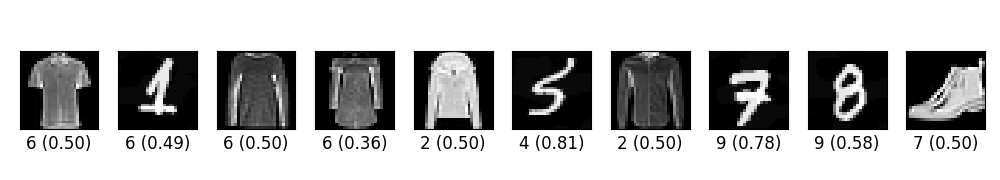

In [98]:
Image.open("img_fashion/ex_00.png")

# Exercise 3


Download the github directory https://github.com/gongzhitaao/tensorflow-adversarial. In the folder "attacks" you will find other attacks in addition to fgsm

3.1) Use the "Jacobian-based Saliency Map Approach" (jsma, available in saliency_map.py) to create adversarial examples using the MNIST dataset and the model previously trained. These examples should get "1" as prediction from the model. 

3.2) Complete the rest of the cells as necessary to plot the adversarial examples.

3.3) Inspect the file img/adv_examples_ones.png.


Suggestion: Copy the content of saliency_map.py to a new cell and modify the "env" environment so you could learn the adversarial examples in a similar way we did before

In [ ]:
def jsma(model, x, y=None, epochs=1, eps=1.0, k=1, clip_min=0.0, clip_max=1.0,
         score_fn=lambda t, o: t * tf.abs(o)):
    pass

In [ ]:
# Collect all tensorflow tensors into one "enviroment" to avoid
# accidental overwriting.
class Dummy:
    pass
env = Dummy()

# We need a scope since the inference graph will be reused later
with tf.variable_scope('model', reuse=tf.AUTO_REUSE):


In [ ]:
# Note the reuse=True flag
with tf.variable_scope('model', reuse=True):
    env.x_adv =     

In [ ]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [ ]:

print('\nTraining')
n_sample = X_train.shape[0]
batch_size = 128
n_batch = int(np.ceil(n_sample/batch_size))

n_epoch = 2 # More epochs might be needed
for epoch in range(n_epoch):
    print('Epoch {0}/{1}'.format(epoch+1, n_epoch))
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        sess.run(env.optim, feed_dict={env.x: X_train[start:end],
                                       env.y: y_train[start:end],
                                       env.training: True})
    _evaluate(X_valid, y_valid, env)
    

print('\nTesting against clean data')
_evaluate(X_test, y_test, env)

save_path = saver.save(sess, "/tmp/mnist_model.ckpt")
print("Model saved in file: %s" % save_path)



In [ ]:

print('\nCrafting adversarial')
n_sample = X_test.shape[0]
batch_size = 128
n_batch = int(np.ceil(n_sample/batch_size))
n_epoch = 20
X_adv = np.empty_like(X_test)
for ind in range(n_batch):
    print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
    start = ind*batch_size
    end = min(n_sample, start+batch_size)
    tmp = sess.run(env.x_adv, feed_dict={env.x: X_test[start:end],
                                         env.y: y_test[start:end],
                                         env.training: False})
    X_adv[start:end] = tmp
print('\nSaving adversarial')
os.makedirs('data', exist_ok=True)
np.save('data/ex_00.npy', X_adv)



In [ ]:
print('\nTesting against adversarial data')
_evaluate(X_adv, y_test, env)


In [ ]:
y1 = _predict(X_test, env)
y2 = _predict(X_adv, env)

In [ ]:
z0 = np.argmax(y_test, axis=1)
z1 = np.argmax(y1, axis=1)
z2 = np.argmax(y2, axis=1)

X_tmp = np.empty((10, 28, 28))
y_tmp = np.empty((10, 10))
fig = plt.figure(figsize=(10, 1.8))
for i in range(10):
    ind, = np.where(np.all([z0==i, z1==i, z2==1], axis=0))
    cur = np.random.choice(ind)
    X_tmp[i] = np.squeeze(X_adv[cur])
    y_tmp[i] = y2[cur]



In [ ]:
print(np.unique(np.argmax(y1, axis=1), return_counts=True))
print(np.unique(np.argmax(y2, axis=1), return_counts=True))

In [ ]:
print('\nPlotting results')
fig = plt.figure(figsize=(10, 1.8))
gs = gridspec.GridSpec(1, 10, wspace=0.1, hspace=0.1)

label = np.argmax(y_tmp, axis=1)
proba = np.max(y_tmp, axis=1)
for i in range(10):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(X_tmp[i], cmap='gray', interpolation='none', vmin=0, vmax=0.005)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('{0} ({1:.2f})'.format(label[i], proba[i]),
                  fontsize=12)

print('\nSaving figure')
gs.tight_layout(fig)
os.makedirs('img28', exist_ok=True)
plt.savefig('img28/adv_examples_ones.png')